# PCA

<a href="https://colab.research.google.com/drive/17ZZ505DP82Ymiaz7oTDOgEeT-xIE_jjJ" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Since python &ge; 3.5 the `@` operator is supported (see [PEP 465](https://www.python.org/dev/peps/pep-0465/)).

In [1]:
import sys

assert sys.version_info[:3] >= (3, 5, 0), "Python version >= 3.5 required"

## Google Colab

In [2]:
if 'google.colab' in str(get_ipython()):
    !pip install ucimlrepo
    !pip install --upgrade scikit-learn

## Import packages

In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo

### Setup plotting

#### matplotlib mode

To make plots using Matplotlib, you must first enable IPython's matplotlib mode.

To do this, run the `%matplotlib` magic command to enable plotting in the current notebook.

This magic takes an optional argument that specifies which MatPlotlib backend should be used.
Most of the time, in the Notebook, you will want to use the `inline` backend, which will display _inline_ within frontends like Jupyter Lab, directly below the code cells that produced them:

In [4]:
%matplotlib inline

See also [Plotting section](https://ipython.readthedocs.io/en/stable/interactive/plotting.html#matplotlib-magic) in IPython tutorial.

In [5]:
import matplotlib.pyplot as plt


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
                '%.2f' % height,
                ha='center', va='bottom')


## Load dataset

Load dataset from the UCI ML Repository, including the dataframes and metadata information.

In [6]:
electrical_grid_stability_simulated_data = fetch_ucirepo(name="Electrical Grid Stability Simulated Data")

Separate the predictors and the labels. Throw away labels because they are not required to perform PCA.

In [7]:
X: pd.DataFrame = electrical_grid_stability_simulated_data.data.features

## Implementation

### Estimate the covariance matrix

Assuming our conventions: we have $m$ instances and $n$ features. Furthermore, let $X_{i}$ is a feature (a.k.a. random variable) with a specific distribution. Then we can estimate covariance between two RVs as

$$\operatorname{Cov}(X_{i}, X_{j}) = \operatorname{E}[(X_{i}-\operatorname{E}[X_{i}])(X_{j}-\operatorname{E}[X_{j}])]=\frac{1}{m-1}\sum_{k=1}^{m}(x_{i}^{(k)}-\mu_{i})(x_{j}^{(k)}-\mu_{j})\qquad 1 \leq i, j \leq n$$

Instead of executing operations on individual array items, one at a time, we can improve efficiency using array operations. This is called _vectorization_.
Let $\hat{\mathbf{X}}$ the data matrix centered. Then we estimate the covariance matrix as

$$\mathbf{\Sigma} = \frac{1}{m-1}\hat{\mathbf{X}}^{T}\hat{\mathbf{X}}$$

In [8]:
X_centered = X - X.mean(axis=0)
empirical_covariance_matrix = X_centered.T @ X_centered / (X_centered.shape[0] - 1)

### Eigen decomposition

Now, we can perform a matrix decomposition on $\mathbf{\Sigma}$ namely the covariance matrix. Note that it is a square, symmetric real-valued $M \times M$ matrix.

In [9]:
U, s, Vt = np.linalg.svd(empirical_covariance_matrix)

### Choosing the Right Number of Dimensions

We want to choose the number of dimensions that add up a sufficiently large portion of the variance, say $95\%$.

In [10]:
total_var = s.sum()
explained_variance_ratio = s / total_var
cumsum = np.cumsum(explained_variance_ratio)
d = np.argmax(cumsum >= .95) + 1
print(f"Number of Dimensions/PCs = {d}")

Number of Dimensions/PCs = 4


An alternative (qualitative) way to choose `d` is to draw a scree plot.

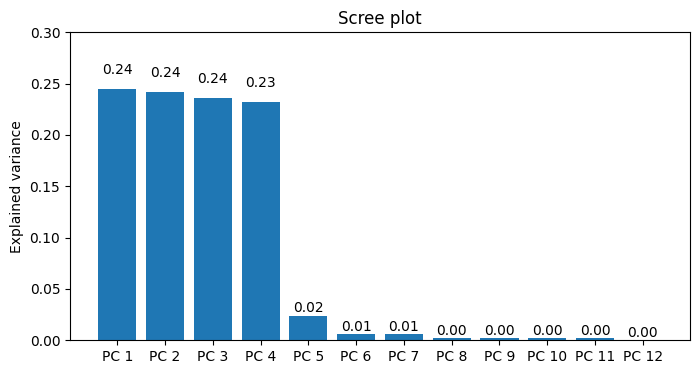

In [11]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)  # 800x400 px

pc_labels = [f"PC {i}" for i in range(1, len(s) + 1)]

bars = ax.bar(pc_labels, explained_variance_ratio)
plt.title("Scree plot")
plt.ylabel("Explained variance")
plt.ylim(0, .3)
autolabel(bars)

plt.show()

### Projecting Down to _d_ Dimensions

To project the training set onto the hyperplane and obtain a reduced dataset $\mathbf{Z} \in \mathbb{R}^{m\times d}$, compute the matrix multiplication of the training set matrix $\mathbf{X}$ by the matrix $\mathbf{U}_{d}$ defined as the matrix containing the first $d$ columns of $\mathbf{U}$.
Note that it is not necessary to traspose $\mathbf{U}_{d}$ because it is sufficient to swap matrix multiplication arguments.

In [12]:
scores = X_centered @ U[:, : d]
scores

0         1         2         3
0     4.928512  3.148424  0.087799  2.468419
1    -4.577635 -3.862714 -0.453112  0.701746
2    -6.400843 -1.733220  0.716594 -1.854001
3     0.402608  0.420274 -2.217471 -5.492782
4     2.690862  3.033227  3.594964 -1.410258
...        ...       ...       ...       ...
9995  0.055776  0.858949  2.948003 -4.804953
9996  4.208955 -2.969770  0.414338  0.693049
9997  0.851884  0.264772 -6.605546 -0.321881
9998 -0.942699 -2.311374  4.061840  3.285112
9999  0.173002  1.178537  3.832951  0.622386

[10000 rows x 4 columns]

## Using Scikit-Learn

The following code is for the comparison with raw implementation above.

In [13]:
pca = PCA(n_components=.95, svd_solver="full")
X_reduced = pca.fit_transform(X)
print(f"Number of Dimensions/PCs = {pca.n_components_}")

Number of Dimensions/PCs = 4


In [14]:
X_reduced

array([[-4.92851245,  3.14842443,  0.08779892,  2.46841929],
       [ 4.57763534, -3.86271388, -0.45311172,  0.70174629],
       [ 6.40084271, -1.73321973,  0.71659415, -1.85400131],
       ...,
       [-0.85188372,  0.26477191, -6.60554604, -0.32188146],
       [ 0.94269881, -2.3113744 ,  4.06184042,  3.28511247],
       [-0.17300166,  1.17853709,  3.83295078,  0.62238632]])

## Using WEKA

Following I show how to get these results using WEKA.
1. Download the dataset and load it.
2. Remove **only** `stab` feature, thus WEKA will use `stabf` like class. But PCA is an unsupervised approach, so the method `initializeAndComputeMatrix` will [remove it](https://git.cms.waikato.ac.nz/weka/weka/-/blob/3cbb52f2172daeab749aedd5afbe1463775ca361/trunk/weka/src/main/java/weka/attributeSelection/PrincipalComponents.java#L520).
   > **Note**<br/>
   > Unfortunately, `weka.filters.unsupervised.attribute.PrincipalComponents` doesn't print a summary report of PCA. But `weka.attributeSelection.PrincipalComponents` does. In particular, it implements the method [`principalComponentsSummary`](https://git.cms.waikato.ac.nz/weka/weka/-/blob/3cbb52f2172daeab749aedd5afbe1463775ca361/trunk/weka/src/main/java/weka/attributeSelection/PrincipalComponents.java#L754-809).
3. Go to `Select attributes` tab.
   > ⚠️ <br/>
   > Even if in this tab [you can select the attribute to use as the class](https://git.cms.waikato.ac.nz/weka/weka/-/blob/3cbb52f2172daeab749aedd5afbe1463775ca361/trunk/wekadocs/manual/explorer.tex#L639-L640), you can also choose `No class` item from the dropdown list. But it doesn't work. Indeed, WEKA always chooses the rightmost column in your dataset.
   > More precisely this issue happens at [line 681](https://git.cms.waikato.ac.nz/weka/weka/-/blob/3cbb52f2172daeab749aedd5afbe1463775ca361/trunk/weka/src/main/java/weka/gui/explorer/AttributeSelectionPanel.java#L681) of the class `AttributeSelectionPanel`. A fast solution can be to change this line into `int classIndex = m_ClassCombo.getSelectedIndex();`.
4. Choose `PrincipalComponents` as evaluator and set [`centerData`](https://git.cms.waikato.ac.nz/weka/weka/-/blob/3cbb52f2172daeab749aedd5afbe1463775ca361/trunk/weka/src/main/java/weka/attributeSelection/PrincipalComponents.java#L118-122) option to `True`.
   > **Note**<br/>
   > You can't set `doNotCheckCapabilities` because it isn't a [proper option](https://git.cms.waikato.ac.nz/weka/weka/-/blob/3cbb52f2172daeab749aedd5afbe1463775ca361/trunk/weka/src/main/java/weka/attributeSelection/PrincipalComponents.java#L214-272).
5. A dialog will appear to ask you if you want that WEKA will automatically choose the Ranker search method. It will [always choose](https://git.cms.waikato.ac.nz/weka/weka/-/blob/3cbb52f2172daeab749aedd5afbe1463775ca361/trunk/weka/src/main/java/weka/gui/explorer/AttributeSelectionPanel.java#L251) `Ranker` class. Anyway, it isn't important because we don't want to do feature selection.

In [15]:
pd.DataFrame(np.column_stack((s[: d], explained_variance_ratio[: d], cumsum[: d])),
             columns=["s", "explained_variance_ratio", "cumsum"])

s  explained_variance_ratio    cumsum
0  7.704473                  0.244466  0.244466
1  7.625168                  0.241950  0.486416
2  7.433167                  0.235858  0.722273
3  7.324641                  0.232414  0.954687

```text
eigenvalue	proportion	cumulative
  7.70447	  0.24447	  0.24447	-0.687tau1+0.523tau4-0.503tau2-0.034tau3-0.005p1...
  7.62517	  0.24195	  0.48642	0.744tau3+0.541tau2+0.359tau4-0.159tau1-0.003p4...
  7.43317	  0.23586	  0.72227	0.709tau4-0.529tau3+0.349tau2+0.31 tau1-0.001p1...
  7.32464	  0.23241	  0.95469	0.637tau1-0.577tau2+0.406tau3+0.309tau4+0.008p1...
```

In [16]:
U[:, : d]

array([[-6.87499379e-01, -1.59245504e-01,  3.09804384e-01,
         6.37110884e-01],
       [-5.02575824e-01,  5.40618314e-01,  3.49436186e-01,
        -5.77088000e-01],
       [-3.39907317e-02,  7.44178030e-01, -5.28957959e-01,
         4.06450917e-01],
       [ 5.23032683e-01,  3.58537907e-01,  7.08598494e-01,
         3.09461890e-01],
       [-5.49967273e-03,  1.37412849e-03, -1.37714650e-03,
         8.15690556e-03],
       [ 2.18556590e-03,  1.15797137e-03,  1.12319049e-03,
        -2.15448317e-03],
       [ 1.81752816e-03,  3.40867881e-04,  1.14423520e-03,
        -2.92015361e-03],
       [ 1.49657868e-03, -2.87296775e-03, -8.90279187e-04,
        -3.08226877e-03],
       [-8.01864673e-04, -1.26863169e-03,  5.98469083e-04,
         1.77798687e-04],
       [-1.39675857e-03,  1.45482664e-03,  1.23034547e-03,
         6.92398493e-04],
       [-6.12382487e-04,  2.11588766e-03, -9.75785001e-06,
        -3.47939865e-04],
       [ 2.26878381e-04, -1.59197881e-03,  3.40301050e-04,
      

```text
Eigenvectors
 V1	 V2	 V3	 V4	
-0.6875	-0.1592	 0.3098	 0.6371	tau1
-0.5026	 0.5406	 0.3494	-0.5771	tau2
-0.034 	 0.7442	-0.529 	 0.4065	tau3
 0.523 	 0.3585	 0.7086	 0.3095	tau4
-0.0055	 0.0014	-0.0014	 0.0082	p1
 0.0022	 0.0012	 0.0011	-0.0022	p2
 0.0018	 0.0003	 0.0011	-0.0029	p3
 0.0015	-0.0029	-0.0009	-0.0031	p4
-0.0008	-0.0013	 0.0006	 0.0002	g1
-0.0014	 0.0015	 0.0012	 0.0007	g2
-0.0006	 0.0021	-0     	-0.0003	g3
 0.0002	-0.0016	 0.0003	 0.0006	g4
```

In [17]:
pca.components_.T

array([[ 6.87499379e-01, -1.59245504e-01,  3.09804384e-01,
         6.37110884e-01],
       [ 5.02575824e-01,  5.40618314e-01,  3.49436186e-01,
        -5.77088000e-01],
       [ 3.39907317e-02,  7.44178030e-01, -5.28957959e-01,
         4.06450917e-01],
       [-5.23032683e-01,  3.58537907e-01,  7.08598494e-01,
         3.09461890e-01],
       [ 5.49967273e-03,  1.37412849e-03, -1.37714650e-03,
         8.15690556e-03],
       [-2.18556590e-03,  1.15797137e-03,  1.12319049e-03,
        -2.15448317e-03],
       [-1.81752816e-03,  3.40867881e-04,  1.14423520e-03,
        -2.92015361e-03],
       [-1.49657868e-03, -2.87296775e-03, -8.90279187e-04,
        -3.08226877e-03],
       [ 8.01864673e-04, -1.26863169e-03,  5.98469083e-04,
         1.77798687e-04],
       [ 1.39675857e-03,  1.45482664e-03,  1.23034547e-03,
         6.92398493e-04],
       [ 6.12382487e-04,  2.11588766e-03, -9.75785001e-06,
        -3.47939865e-04],
       [-2.26878381e-04, -1.59197881e-03,  3.40301050e-04,
      

You can notice that eigenvectors calculated by Scikit-Learn and WEKA are different. Well, the method [`_fit_full`](https://github.com/scikit-learn/scikit-learn/blob/d797b771f1ac5085583df766e7a945d9b22679fa/sklearn/decomposition/_pca.py#L518-L603) in Scikit-Learn does a proper SVD on _non-symmetric non-squared_ data matrix while WEKA does an eigen decomposition on _squared symmetric real matrix_ (e.g. covariance matrix). For the latter, [eigenvalue and singular value decompositions are _mathematically_ the same](https://stats.stackexchange.com/questions/314046/why-does-andrew-ng-prefer-to-use-svd-and-not-eig-of-covariance-matrix-to-do-pca#comment596077_314046). _Numerically_ they might indeed use different algorithms, and one might be more stable than another.
To be more precise, WEKA uses the class [`SymmDenseEVD`](https://github.com/fommil/matrix-toolkits-java/blob/master/src/main/java/no/uib/cipr/matrix/SymmTridiagEVD.java) from an [external library](https://github.com/fommil/matrix-toolkits-java) to compute eigenvectors and eigenvalue. Furthermore, it internally uses a special class ([`UpperSymmDenseMatrix`](https://github.com/fommil/matrix-toolkits-java/blob/6157618bc86bcda3749af2a60bf869d8f3292960/src/main/java/no/uib/cipr/matrix/UpperSymmDenseMatrix.java#L53-L65)) to represent a covariance matrix for efficiency reason.
But why do eigenvectors calculated by my implementation have a different sign? After all I used `svd`? Well, before SVD calculates eigenvalues then eigenvectors. But every eigenvalue has one unique [_eigenspace_](https://math.stackexchange.com/a/235445) that contains _similar_ eigenvectors. `_fit_full` solves this _nondeterministic_ behaviour using a specific method: [`svd_flip`](https://github.com/scikit-learn/scikit-learn/blob/d797b771f1ac5085583df766e7a945d9b22679fa/sklearn/utils/extmath.py#L851-L906).